
# Graph Embeddings

In this notebook we'll learn how to use a graph embedding algorithm called DeepGL. We built an implementation of this in collaboration with Pete Meltzer from [BrainTree](http://braintree.com/), an AI consultancy and research company.

Embedding algorithms have become popular in recent years, and Airbnb have their own custom one for doing [listing recommendations](https://medium.com/airbnb-engineering/listing-embeddings-for-similar-listing-recommendations-and-real-time-personalization-in-search-601172f7603e).

Embedding algorithms take a while to run on bigger datasets, and our implementation isn't yet optimised so we'll run it on a small dataset to gain an understanding about this approach.

One of DeepGL's benchmark datasets is an email network, and our goal is to try and classify the emails based on the embeddings. 

Before you run this notebook create another database in your project and copy across the ml-models and Graph Algorithms plugins. 


In [1]:
from py2neo import Graph
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_colwidth', -1)

In [2]:
graph = Graph("bolt://localhost", auth=("neo4j", "neo"))

We're going to use an email dataset from SNAP, which contains relationships representing emails send between members of a European Research institution. Each node also has one community associated with it:

<div>
    <img align="left" src="images/email_dataset.png" alt="Graph Model" width="500px"/>
</div>

We can import the email dataset using the following code:

In [4]:
edge_list_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.edgelist"
labels_file = "https://github.com/meltzerpete/Embedding-Vis/raw/master/emails/emails.labels"

graph.run("CREATE CONSTRAINT ON (n:Node) ASSERT n.id IS UNIQUE")
    
result = graph.run("""\
    LOAD CSV FROM $edgelistFile AS row
    FIELDTERMINATOR " "
    MERGE (e1:Node {id: row[0]})
    MERGE (e2:Node {id: row[1]})
    MERGE (e1)-[:LINK]->(e2)
    """, {"edgelistFile": edge_list_file})
print(result.summary().counters)

result = graph.run("""\
    LOAD CSV FROM $labelsFile AS row
    FIELDTERMINATOR " "
    MATCH (e:Node {id: row[0]})
    SET  e.label = toInteger(row[1])-1
    """, {"labelsFile": labels_file})
print(result.summary().counters)

{}
{'properties_set': 1005}


Now that we've done that we can run the embedding algorithm over the graph. We can optionally pass in several parameters to the algorithm:

* `pruningLambda` - similarity cut off used when pruning features after each iteration. The lower this value is, the more aggressively features will be pruned  
* `iterations` - the number of iterations that the algorithm should run. 
* `diffusions` - the number of rounds of diffusion of embeddings that should happen per iteration 

In [4]:
embedding_property_name  = "deepglEmbedding"

In [6]:
pruning_lambda = 0.6
diffusions = 3
iterations = 2

params = {
    "writeProperty": embedding_property_name,
    "pruningLambda": pruning_lambda,
    "diffusions": diffusions,
    "iterations": iterations
}
result = graph.run("""
CALL embedding.deepgl("Node", "LINK", {
  pruningLambda: $pruningLambda,
  diffusions: $diffusions,
  iterations: $iterations,
  writeProperty: $writeProperty
})
""", params)
print(result.data())

[{'loadMillis': 53, 'computeMillis': 75333, 'writeMillis': 112, 'nodes': 1005, 'writeProperty': 'deepglEmbedding', 'embeddingSize': 108, 'numberOfLayers': 3, 'features': ['diffuse( mean_in_neighbourhood( hadamard_in_neighbourhood( IN_DEGREE)))', 'diffuse( hadamard_out_neighbourhood( OUT_DEGREE))', 'diffuse( mean_in_neighbourhood( mean_in_neighbourhood( IN_DEGREE)))', 'IN_DEGREE', 'max_both_neighbourhood( rbf_in_neighbourhood( IN_DEGREE))', 'max_both_neighbourhood( IN_DEGREE)', 'max_out_neighbourhood( mean_out_neighbourhood( IN_DEGREE))', 'max_out_neighbourhood( diffuse( hadamard_in_neighbourhood( IN_DEGREE)))', 'diffuse( rbf_in_neighbourhood( rbf_out_neighbourhood( IN_DEGREE)))', 'diffuse( rbf_in_neighbourhood( diffuse( mean_in_neighbourhood( IN_DEGREE))))', 'max_out_neighbourhood( rbf_out_neighbourhood( IN_DEGREE))', 'diffuse( rbf_in_neighbourhood( diffuse( rbf_out_neighbourhood( IN_DEGREE))))', 'max_out_neighbourhood( rbf_both_neighbourhood( IN_DEGREE))', 'max_out_neighbourhood( sum_

Next we're going to use these embeddings in a machine learning algorithm. Our classifier expects that label values increase incrementally from 0 so we'll create an `mlLabel` property on each node to store these labels. We're only going to do this for labels that have at least 50 items.

In [8]:
result = graph.run("""\
MATCH (n:Node) 
WITH n.label as class, count(*) AS c
ORDER BY c DESC
WITH class WHERE c > 50
WITH class ORDER BY class
with collect(class) AS biggestClasses
MATCH (p:Node) WHERE p.label IN biggestClasses
SET p.mlLabel = apoc.coll.indexOf(biggestClasses, p.label)
""")
print(result.summary().counters)

{'properties_set': 433}


Now let's write a query to get back the embeddings for each node along with its actual label:

In [5]:
result = graph.run("""\
MATCH (p:Node) 
WHERE exists(p.mlLabel)
RETURN p.`%s` AS embedding, p.mlLabel AS label, p.label as initialLabel
ORDER BY label
""" % embedding_property_name)

df = result.to_data_frame()

emb = df["embedding"].apply(pd.Series).values
labels = df["label"].values
emb.shape

(433, 108)

We can create a heatmap and scatterplot of our embeddings by running the following code. If two values in the matrix are similar they will be in dark blue. Since we've ordered the items in our DataFrame by label, we should expect there to be areas of blue around the diagonals of the matrix going from top left to bottom right:

/Users/markneedham/neo/training/t/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


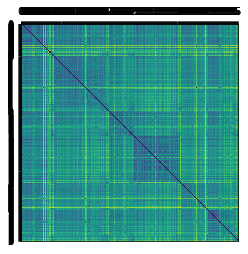

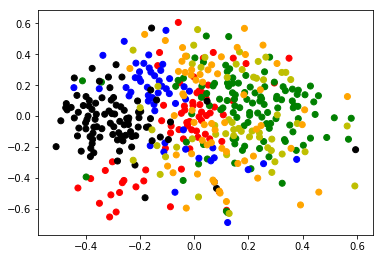

In [13]:
# Heatmap
colours = ['r', 'g', 'b', 'black', 'y', 'orange']
cols = pd.DataFrame(labels).apply(lambda x: colours[int(x)], axis=1).values

dist = np.ndarray([len(emb), len(emb)])

for i, e1 in enumerate(emb):
    for j, e2 in enumerate(emb):
        dist.itemset((i, j), np.linalg.norm(e1 - e2, 2))

plt.imshow(dist)
plt.axes().xaxis.tick_top()
plt.xticks(np.arange(len(dist)), labels)
plt.yticks(np.arange(len(dist)), labels)
plt.show()

# 2D Visualisation
# from: https://baoilleach.blogspot.com/2014/01/convert-distance-matrix-to-2d.html
adist = dist
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.subplots_adjust(bottom=0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker='o', c=cols
)

plt.show()

Now we can run the embeddings through a neural network. There are several different libraries that we could use here, but scikit-learn has a Multi Layer Perceptron classifier which is configurable in minimal lines of code:

In [28]:
X = pd.DataFrame(emb)
y = labels

X = StandardScaler().fit_transform(X)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.4, random_state=42)

# can we tag the database with which nodes are in the test and training sets

clf = MLPClassifier(solver='sgd',
                    activation='tanh',
                    learning_rate_init=0.001,
                    alpha=1e-5,
                    hidden_layer_sizes=(30, 30),
                    max_iter=10000,
                    batch_size=X.shape[0],
                    random_state=0)

display(clf.fit(train_x, train_y))

mean_acc = clf.score(test_x, test_y)
display(mean_acc)

/Users/markneedham/neo/training/t/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:358: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


MLPClassifier(activation='tanh', alpha=1e-05, batch_size=433, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

0.896551724137931

Our classifier is getting an accuracy of just under 90%.

Let's store our predictions in the database and then write a query to check the predictions against actual labels to make sure everything makes sense.


In [29]:
result = graph.run("""\
MATCH (n:Node) 
WHERE exists(n.mlLabel)
RETURN n.mlLabel = n.prediction AS correct, count(*) AS count
""")
df = result.to_data_frame()
df

,correct,count
0,False,74
1,True,359


We can then write the following code to check the accuracy of our predictions as a %:

In [17]:
false_predictions = df.loc[df["correct"] == False]["count"].item()
true_predictions = df.loc[df["correct"] == True]["count"].item()

true_predictions / (true_predictions + false_predictions)

0.8290993071593533

This is slightly lower than the score above, but remember that this is across the whole dataset rather than just the test set.

Next we're going to compare the embeddings against each other and build an embedding similarity graph.

First let's run the Cosine Similarity algorithm to find similar embeddings:

In [18]:
similarity_query = """
MATCH (n:Node)
WITH {item:id(n), weights: n.deepglEmbedding} as userData
WITH collect(userData) as data
CALL algo.similarity.cosine.stream(data, {concurrency: 1, topK: 3})
YIELD item1, item2, similarity
RETURN item1, item2, similarity
ORDER BY item1 DESC
LIMIT 10
"""

result = graph.run(similarity_query).to_table()
result

item1,item2,similarity
1979989,1979943,0.7873997893118968
1979989,1979963,0.78901603312909
1979989,1979915,0.809234314540649
1979988,1979950,0.8363656655770324
1979988,1979933,0.8278346352274969
1979988,1979916,0.9643557780915447
1979987,1979949,0.8031527752028929
1979987,1979959,0.9801383366799044
1979987,1979948,0.7936513348699203
1979986,1979971,0.8778123050640684


Now we'll use the `topK` variant to find the 3 most similar nodes for each node and create a `SIMILAR` relationship between nodes:

In [20]:
similarity_query = """
MATCH (n:Node)
WITH {item:id(n), weights: n.deepglEmbedding} as userData
WITH collect(userData) as data
CALL algo.similarity.cosine(data, {concurrency: 1, topK: 3, similarityCutoff: 0.2, write: true})
YIELD nodes, similarityPairs, write, writeRelationshipType, writeProperty, p50, p75, p90, p99, p999, p100
RETURN nodes, similarityPairs, write, writeRelationshipType, writeProperty, p50, p75, p90, p99, p999, p100
"""

result = graph.run(similarity_query).to_table()
result

nodes,similarityPairs,write,writeRelationshipType,writeProperty,p50,p75,p90,p99,p999,p100
1005,3015,true,SIMILAR,score,0.789031982421875,0.8382530212402344,0.881072998046875,0.9982414245605469,1.0000038146972656,1.0000038146972656


Now let's write a query to find similar nodes:

In [31]:
find_similar_nodes_query = """
MATCH (n:Node {id: $id})-[similar:SIMILAR]->(other)
RETURN n.id, n.label, other.id, other.label, similar.score
"""
    
result = graph.run(find_similar_nodes_query, {"id": "40"}).to_data_frame()
result

,n.id,n.label,other.id,other.label,similar.score
0,40,10,29,10,0.856151
1,40,10,27,10,0.820874
2,40,10,339,12,0.817632


We would hope that similar nodes would have the same label which is the case here. Try changing the 'id' parameter to explore other nodes similar neighbors.